In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import requests
# from astroquery import sdss
import glob

In [2]:
# want to access bright objects from the PCC
df0 = pd.read_fwf('PCC_cat.txt', header=None)
# df0

In [3]:
## Unused??? to check balance of labels within dataframe
# def checkBalance(df):
#     all_labels = df['labels']
#     all_labels = all_labels.tolist()
#     balance = df['labels'].value_counts()
#     print(balance)
#     for i in range(len(balance)):
#         print(f'{balance[i]*100/df.size:.2f} %')

In [4]:
# threshold for the r-band -- the lower the brighter
rmag_threshold = 19.4
bright = np.where(df0[4] <= rmag_threshold)
brightDF = df0.iloc[bright].copy()

In [5]:
labels = np.unique(brightDF[21])

# access ra and dec from their columns in the dataframe
names = brightDF[1]
ra = brightDF[2]
dec = brightDF[3]

filenames = []
for r, d in zip(ra, dec):
    fn = f'sdss_ra={r}_dec={d}.png'
    filenames.append(fn)

brightDF_reduced = pd.DataFrame({'files' : filenames,
                                 'name': names,
                                 'labels': brightDF[21],
                                 'ra': ra,
                                 'dec': dec})

# brightDF_reduced = pd.DataFrame({'name': names,
#                                  'ra':ra,
#                                  'dec':dec})
# brightDF_reduced

In [6]:
## Copying logic from the reduction of labels to binary

# checkBalance(brightDF_reduced)
df1 = brightDF_reduced
unique_labels = np.unique(df1['labels'])

clusterBG_LTG = df1.loc[(df1['labels']==unique_labels[0])]
BG_ETG = df1.loc[(df1['labels']==unique_labels[1])]
clusterBG_edgeDisk = df1.loc[(df1['labels']==unique_labels[2])]
likely_dE_ETGcluster = df1.loc[(df1['labels']==unique_labels[3])]
likely_merging = df1.loc[(df1['labels']==unique_labels[4])]
poss_dE_ETGcluster = df1.loc[(df1['labels']==unique_labels[5])]
weak_bg = df1.loc[(df1['labels']==unique_labels[6])]

downSampleDf0 = pd.concat([clusterBG_LTG, # 384
                         BG_ETG.sample(frac = 400/3008),
                         clusterBG_edgeDisk.sample(frac = 400/1049),
                         likely_dE_ETGcluster, # 398
                         likely_merging, # 23
                         poss_dE_ETGcluster, # 98
                         weak_bg # 477
                         ])
# checkBalance(downSampleDf0)

def replace(df, ind):
    label = list(df['labels'])[0]
    newDf = df.replace(label, str(ind))
    return(newDf)


# combined 3 and 5
second = pd.concat([
                    replace(likely_dE_ETGcluster, 1), # old 3
                    replace(poss_dE_ETGcluster, 1) # old 5
                    ])
# combine 0,1,2,6
first = pd.concat([replace(clusterBG_LTG, 0), # old 0
                   replace(BG_ETG, 0), # old 1
                   replace(clusterBG_edgeDisk, 0), # old 2
                   replace(weak_bg, 0) # old 6
                    ])

lenSecond = len(second.index)
lenFirst = len(first.index)

downSampleDf1 = pd.concat([first.sample(frac = lenSecond/lenFirst), second])

# 0 is background
# 1 is dE/ETGcluster


# remove red contaminants / hot pixel images
downFiles = downSampleDf1['files']
redPercent = [None]*len(downFiles)
counter = 0
workDir = 'SDSS-png/'

# lower boundary RED color range values; Hue (0 - 10)
lower1 = np.array([0, 80, 20])
upper1 = np.array([10, 255, 255])
 
# upper boundary RED color range values; Hue (160 - 180)
lower2 = np.array([160, 100, 20])
upper2 = np.array([179, 255, 255])

for i, x in enumerate(downFiles):
    testImgPath = os.path.join(workDir, x)
    image = cv2.imread(testImgPath)
    result = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    lower_mask = cv2.inRange(image, lower1, upper1)
    upper_mask = cv2.inRange(image, lower2, upper2)
    full_mask = lower_mask + upper_mask;

    result = cv2.bitwise_and(result, result, mask=full_mask)
    dim = np.shape(full_mask)[0] 
    counts = np.count_nonzero(full_mask)
#     print(counts)
#     print(dim**2)
    percent = 100*counts/dim**2
    redPercent[i] = percent
    subtitle_string = f'{percent}% of the image is red'
    filename = testImgPath.split('\\')[-1]
#     print(f'{filename}, {subtitle_string}')
#     if percent > 50.0:
#         counter += 1
# #         print('To be removed')
#     else:
#         pass

downSampleDf1['reds'] = redPercent # add new column of the red percentage of an image
# downSampleDf1
redList = (downSampleDf1['reds'] >= 50) # percentage threshold of how much red is in the image
# downSampleDf1.shape
df_filtered = downSampleDf1[downSampleDf1['reds'] <= 50]
df_filtered.shape

(230, 6)

In [7]:
# shuffle order of columns for crossmatch order (ra and dec must be last)
df_filtered = df_filtered.iloc[:,[0, 1, 2, 5, 3, 4]]
df_filtered


,files,name,labels,reds,ra,dec
3027,sdss_ra=49.7006_dec=41.4398.png,PCC-3028,0,9.2150,49.7006,41.4398
2328,sdss_ra=49.6164_dec=41.4551.png,PCC-2329,0,1.3825,49.6164,41.4551
3312,sdss_ra=49.7345_dec=41.6346.png,PCC-3313,0,4.3675,49.7345,41.6346
1741,sdss_ra=49.5319_dec=41.5225.png,PCC-1742,0,2.4475,49.5319,41.5225
214,sdss_ra=49.2828_dec=41.3936.png,PCC-0215,0,4.5200,49.2828,41.3936
...,...,...,...,...,...,...
5338,sdss_ra=49.9932_dec=41.5479.png,PCC-5339,1,28.4075,49.9932,41.5479
5357,sdss_ra=49.9947_dec=41.75.png,PCC-5358,1,49.0425,49.9947,41.7500
5373,sdss_ra=49.9967_dec=41.3092.png,PCC-5374,1,17.3550,49.9967,41.3092
4501,sdss_ra=49.8825_dec=41.7447.png,PCC-4502,1,4.6300,49.8825,41.7447


In [8]:
# this is the input csv to the crossmatch
df_filtered.to_csv('brightPCC.csv', index = False)


## This part should be automate-able with SDSS-query

In [9]:
# output csv from crossmatch
bright_csv = 'PCC_CrossMatch.csv'
brightDF1 = pd.read_csv(bright_csv, skiprows = 1)
brightDF1

,files,name,labels,reds,objID,type,ra,dec,modelMag_r,u_g,g_z,g_r,g_i,r_i,r_z,petroRad_r
0,sdss_ra=49.9985_dec=41.3856.png,PCC-5387,0,3.3975,1237661055281858002,GALAXY,49.998486,41.385606,18.58372,2.330160,2.217403,1.269188,1.837666,0.568478,0.948215,5.380006
1,sdss_ra=49.5411_dec=41.5389.png,PCC-1795,0,6.0250,1237661055281661552,GALAXY,49.541127,41.538935,17.08435,1.635536,1.695250,0.960300,1.370968,0.410667,0.734949,10.597430
2,sdss_ra=49.6769_dec=41.3202.png,PCC-2835,0,5.0100,1237661122387968404,GALAXY,49.676896,41.320255,23.41172,1.138586,0.929184,-2.633751,0.937946,3.571697,3.562935,0.209667
3,sdss_ra=49.6116_dec=41.197.png,PCC-2283,0,1.5825,1237661083199210860,GALAXY,49.611574,41.197021,19.48380,1.099449,1.053764,0.697296,0.955110,0.257814,0.356468,2.064733
4,sdss_ra=50.0028_dec=41.3384.png,PCC-5417,0,3.2525,1237661055281857479,GALAXY,50.002733,41.338369,18.87916,2.246117,2.017632,1.125536,1.634195,0.508659,0.892096,2.361201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,sdss_ra=49.9932_dec=41.5479.png,PCC-5339,1,28.4075,1237661059574334453,STAR,50.017209,41.548275,21.31716,0.580925,3.674906,1.534445,2.881615,1.347170,2.140461,3.350529
226,sdss_ra=49.9947_dec=41.75.png,PCC-5358,1,49.0425,1237670960021504409,GALAXY,49.994725,41.750034,17.53399,6.157221,1.576391,0.871559,1.323565,0.452005,0.704832,8.789475
227,sdss_ra=49.9967_dec=41.3092.png,PCC-5374,1,17.3550,1237661055281857031,STAR,49.996200,41.309363,22.91631,1.041622,1.991064,1.159723,1.114315,-0.045408,0.831341,1.055185
228,sdss_ra=49.8825_dec=41.7447.png,PCC-4502,1,4.6300,1237670458048446875,GALAXY,49.882513,41.744532,19.29449,3.955753,-0.534899,0.685694,1.386385,0.700691,-1.220592,7.691484


In [10]:
# brightDF2 = display(brightDF1.loc[(brightDF1['modelMag_r'] < 17.3) & (brightDF1['u_g'] < 2.5)])

brightDF2 = brightDF1.loc[(brightDF1['modelMag_r'] < rmag_threshold) \
                          & (brightDF1['u_g'] < 2.5) \
#                           & (brightDF1['petroRad_r'] < 50) \ # weird incredibly high petroRad_r?
                          & (brightDF1['g_z'] < 2.2)]
# brightDF2 = brightDF1.loc[(brightDF1['modelMag_r'] < rmag_threshold)]

pairDf = brightDF2[['u_g', 'g_z', 'g_r', 'g_i', 'r_i', 'r_z', 'modelMag_r','petroRad_r','labels']]
pairDf

,u_g,g_z,g_r,g_i,r_i,r_z,modelMag_r,petroRad_r,labels
1,1.635536,1.695250,0.960300,1.370968,0.410667,0.734949,17.08435,10.597430,0
4,2.246117,2.017632,1.125536,1.634195,0.508659,0.892096,18.87916,2.361201,0
8,1.262079,0.737644,0.458859,0.649113,0.190254,0.278786,18.66884,1.323857,0
11,1.302483,0.792460,0.511456,0.713074,0.201617,0.281004,15.49529,1.069027,0
12,1.617607,2.170547,1.181578,1.761650,0.580072,0.988970,19.18396,2.971488,0
...,...,...,...,...,...,...,...,...,...
219,1.302105,1.511499,0.821907,1.175476,0.353569,0.689592,19.37686,3.857142,1
220,1.974316,1.445345,0.867374,1.316496,0.449122,0.577971,18.71980,3.942765,1
222,0.217379,1.436186,0.775021,0.852034,0.077013,0.661165,14.49405,258.411600,1
223,1.906456,1.674442,0.899385,1.351961,0.452576,0.775057,15.59959,12.831900,1


In [11]:

# brightDF2 = brightDF1.query('modelMag_r < 17.3')
# brightDF3 = brightDF2.query('u_g < 2.5')
# brightDF3

gz_lim = (1.25, 2.00)
ug_lim = (1.45, 2.30)
# modMagr_lim = (14.0, 18.00)
modMagr_lim = (14.0, 20)
petroRad_r_lim = (0, 20)

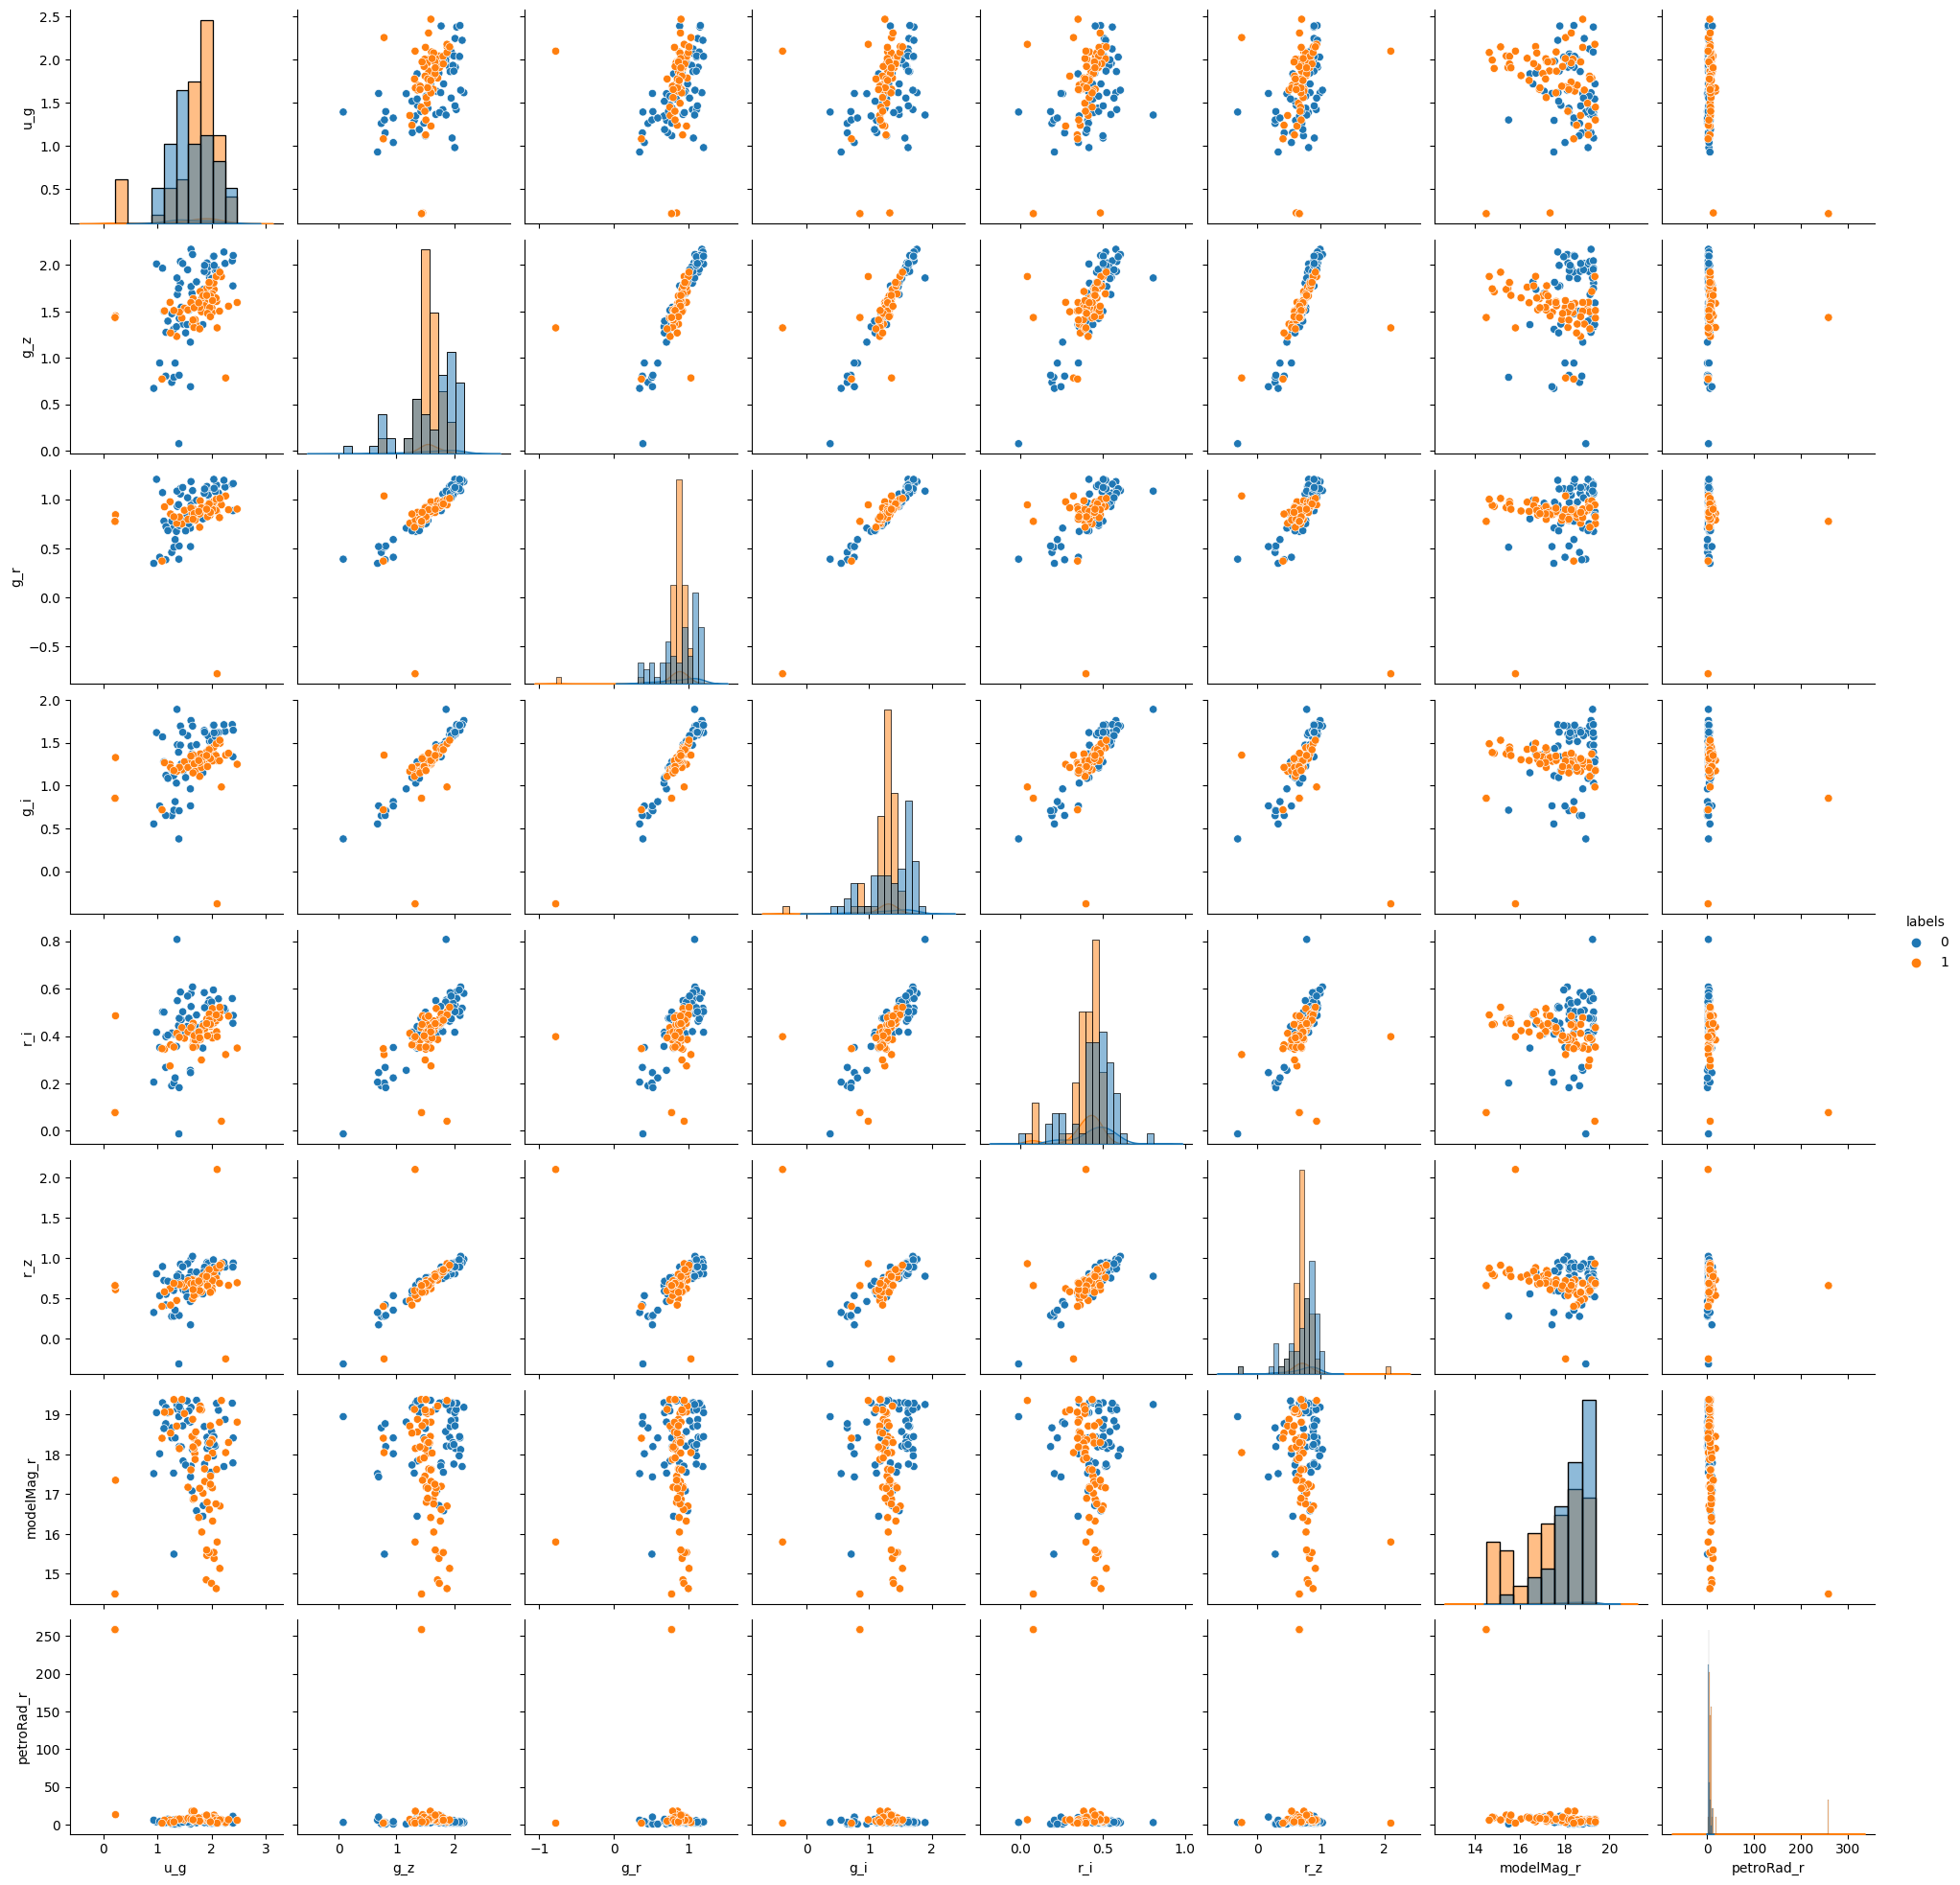

In [12]:
# brightPair = 
p1 = sns.pairplot(pairDf, corner = False, hue = 'labels')
p1.map_diag(sns.histplot)

# ## set column x lims
# p1.axes[0, 0].set_xlim(ug_lim[::-1])
# p1.axes[0, 1].set_xlim(gz_lim[::-1])
# p1.axes[0, 2].set_xlim(modMagr_lim[::-1])
# p1.axes[0, 3].set_xlim(petroRad_r_lim[::-1])

# ## set row y lims
# p1.axes[0, 0].set_ylim(ug_lim[::-1])
# p1.axes[1, 0].set_ylim(gz_lim[::-1])
# p1.axes[2, 0].set_ylim(modMagr_lim[::-1])
# p1.axes[3, 0].set_ylim(petroRad_r_lim[::-1])


In [13]:
# p2 = sns.pairplot(pairDf, hue = 'labels', corner = True, kind = 'kde')

In [14]:
# x1 = pairDf['u_g']
# x2 = pairDf['g_z']
# plt.figure()
# plt.plot(x1, x2, 'o')
# plt.xlabel('u_g')
# plt.ylabel('g_z')

(0.0, 20.0)

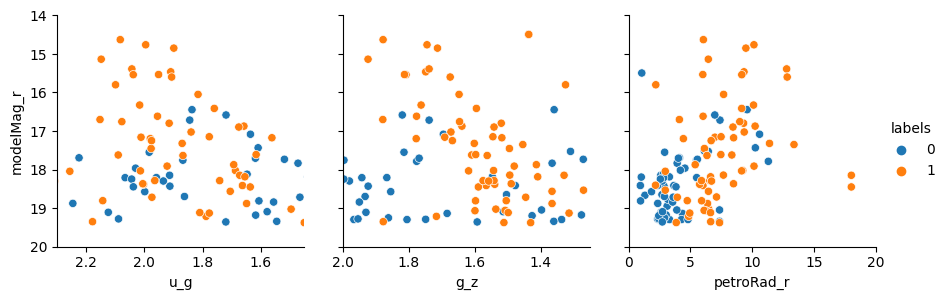

In [15]:
# x_vars = ["u_g", "g_z", "modelMag_r", "petroRad_r"]
x_vars = ["u_g", "g_z", "petroRad_r"]
y_vars = ["modelMag_r"]
g = sns.PairGrid(pairDf, hue="labels", x_vars=x_vars, y_vars=y_vars, height = 3)
# g.map_diag(sns.histplot, color=".3")
g.map_offdiag(sns.scatterplot)
g.add_legend()
g.axes[0, 0].set_ylim(modMagr_lim[::-1])
g.axes[0, 0].set_xlim(ug_lim[::-1])
g.axes[0, 1].set_xlim(gz_lim[::-1])
g.axes[0, 2].set_xlim(petroRad_r_lim)

(0.0, 20.0)

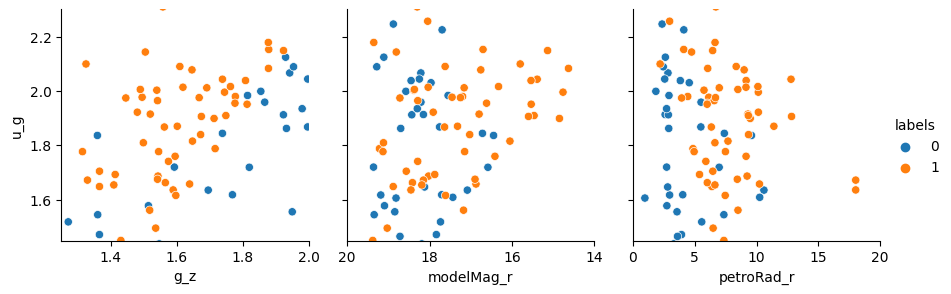

In [16]:
x_vars = ["g_z", "modelMag_r", "petroRad_r"]
y_vars = ["u_g"]
f = sns.PairGrid(pairDf, hue="labels", x_vars=x_vars, y_vars=y_vars, height = 3)
# f.map_diag(sns.histplot, color=".3")
f.map_offdiag(sns.scatterplot)
f.add_legend()
f.axes[0, 0].set_ylim(ug_lim)
f.axes[0, 0].set_xlim(gz_lim)
f.axes[0, 1].set_xlim(modMagr_lim[::-1])
f.axes[0, 2].set_xlim(petroRad_r_lim)

(0.0, 20.0)

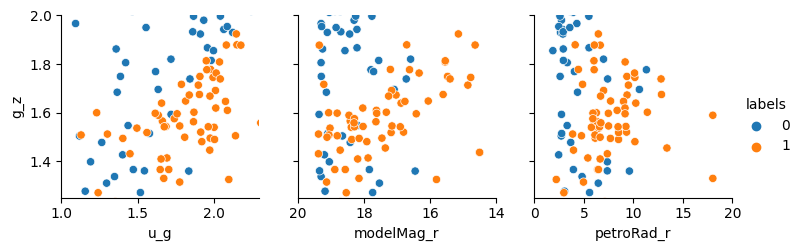

In [17]:
x_vars = ["u_g", "modelMag_r", "petroRad_r"]
y_vars = ["g_z"]
h = sns.PairGrid(pairDf, hue="labels", x_vars=x_vars, y_vars=y_vars)
# f.map_diag(sns.histplot, color=".3")
h.map_offdiag(sns.scatterplot)
h.add_legend()
h.axes[0, 0].set_ylim(gz_lim)
# h.axes[0, 0].set_xlim(ug_lim)
h.axes[0, 0].set_xlim((1, 2.3))

h.axes[0, 1].set_xlim(modMagr_lim[::-1])
h.axes[0, 2].set_xlim(petroRad_r_lim)

In [18]:
# ug_lim

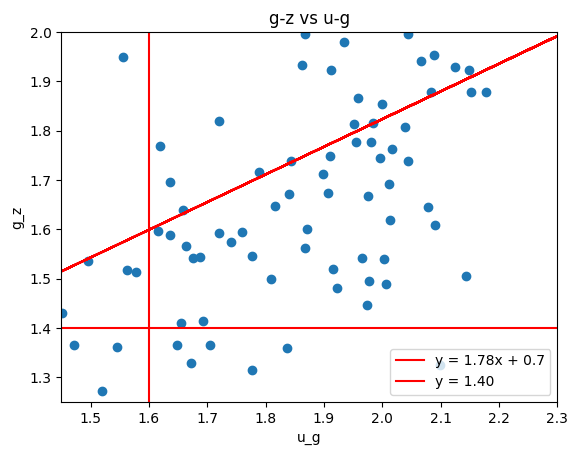

In [19]:
pairDf2 = brightDF1.loc[(brightDF1['modelMag_r'] < rmag_threshold) \
#                           & (brightDF1['u_g'] < 1.7) \
                          & (brightDF1['u_g'] < 2.3) \
                          & (brightDF1['g_z'] < 2.2) \
                          & (brightDF1['g_z'] > 1.6)]

# 1.6 < g_z < 2.2
# u_g > 1.7

top_slope = 1.78
bot_slope = 1.1
bot_intercept = -.20
top_intercept = .70

x1 = pairDf['u_g']
x2 = pairDf['g_z']

x3 = pairDf['modelMag_r']

plt.figure()
plt.plot(x1, x2, 'o')
plt.plot(top_slope*x1, x1 + top_intercept, 'r-', label = f'y = {str(top_slope)}x + {str(top_intercept)}')
# plt.plot(bot_slope*x1, x1 + bot_intercept, 'ro', label =  f'y = x + {str(bot_intercept)}')
plt.ylim(gz_lim)
plt.xlim(ug_lim)
# plt.axhline(y=1.65)
plt.axhline(y=1.40, color = 'r', label = 'y = 1.40')
plt.axvline(x=1.60, color = 'r')
plt.xlabel('u_g')
plt.ylabel('g_z')
plt.title('g-z vs u-g')
plt.legend()
plt.show()

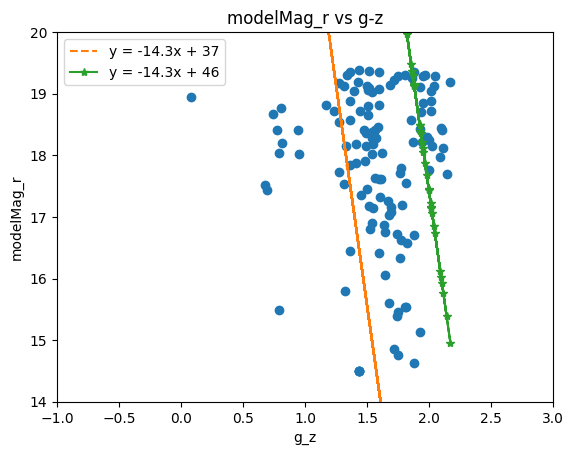

In [20]:
gz_slope = -14.3
gz_intercept1 = 37
gz_intercept2 = 46 # is this one intense enough?

plt.figure()
plt.plot(x2, x3, 'o')
plt.plot(x2, x2*gz_slope + gz_intercept1, '--', label = f'y = {str(gz_slope)}x + {str(gz_intercept1)}')
plt.plot(x2, x2*gz_slope + gz_intercept2, '*-', label = f'y = {str(gz_slope)}x + {str(gz_intercept2)}')
plt.ylim(modMagr_lim)
# # plt.xlim(gz_lim)
plt.xlim((-1, 3))
# plt.axvline(x=1.90, color = 'r')
# plt.axvline(x=1.85, color = 'r', label = 'x = 1.85')
# plt.axvline(x=1.30, color = 'r', label = 'x = 1.30')
# plt.axvline(x=1.575, color = 'r', label = 'x = 1.575')
plt.ylabel('modelMag_r')
plt.xlabel('g_z')
plt.title('modelMag_r vs g-z')
plt.legend()
plt.show()

# Visualizing those bottom right background galaxies:

In [21]:
# 1.6 < g_z < 2.2
# u_g > 1.7

bgBlues = brightDF1.loc[(brightDF1['modelMag_r'] < rmag_threshold) \
                          & (brightDF1['u_g'] < 1.75) \
#                           & (brightDF1['g_z'] < 2.2) \
                          & (brightDF1['g_z'] > 1.65)]

In [22]:
bgBlues

,files,name,labels,reds,objID,type,ra,dec,modelMag_r,u_g,g_z,g_r,g_i,r_i,r_z,petroRad_r
1,sdss_ra=49.5411_dec=41.5389.png,PCC-1795,0,6.0250,1237661055281661552,GALAXY,49.541127,41.538935,17.08435,1.635536,1.695250,0.960300,1.370968,0.410667,0.734949,10.597430
12,sdss_ra=49.5082_dec=41.4069.png,PCC-1581,0,2.4000,1237661055281727219,GALAXY,49.508150,41.406864,19.18396,1.617607,2.170547,1.181578,1.761650,0.580072,0.988970,2.971488
13,sdss_ra=49.3431_dec=41.5987.png,PCC-0571,0,1.5575,1237661055281595489,GALAXY,49.343134,41.598688,19.15490,1.603796,2.307459,1.289614,1.916906,0.627293,1.017845,3.182990
14,sdss_ra=49.4477_dec=41.575.png,PCC-1191,0,1.6075,1237661055281661072,GALAXY,49.447693,41.575002,19.28125,1.179611,2.363596,1.374626,1.845175,0.470549,0.988970,2.867623
21,sdss_ra=49.5885_dec=41.6896.png,PCC-2087,0,2.3900,1237661059574204597,GALAXY,49.588519,41.689635,19.13894,1.366329,1.683722,0.928186,1.477312,0.549126,0.755535,4.349349
23,sdss_ra=49.7118_dec=41.7236.png,PCC-3109,0,1.4800,1237661059574204815,GALAXY,49.711796,41.723620,19.05034,0.982435,2.012373,1.204248,1.620054,0.415806,0.808125,3.903545
24,sdss_ra=49.5591_dec=41.5027.png,PCC-1896,0,12.3575,1237661055281660810,GALAXY,49.559112,41.502695,18.12185,1.647087,2.114698,1.089037,1.696108,0.607071,1.025661,2.813462
28,sdss_ra=49.242_dec=41.4454.png,PCC-0011,0,0.2400,1237661083199080163,GALAXY,49.242027,41.445334,19.29897,1.421982,1.805445,1.054596,1.473343,0.418747,0.750849,3.312139
30,sdss_ra=49.6184_dec=41.4546.png,PCC-2341,0,1.7125,1237661055281726881,GALAXY,49.618438,41.454555,18.95229,1.717859,2.589348,1.567730,2.206661,0.638931,1.021618,2.714802
39,sdss_ra=49.5132_dec=41.3783.png,PCC-1617,0,2.0275,1237661122387903799,GALAXY,49.513169,41.378310,19.12683,1.423109,2.038162,1.110929,1.696451,0.585522,0.927233,2.729274


In [23]:
names = bgBlues['name']
names = names.to_list()

# for i, x in enumerate(pairDf2['files']):
# #     print(i)
#     path = os.path.join('SDSS-png', x)
#     image = cv2.imread(path)
#     image = image[:,:,::-1] ## currently in bgr, needs to be rgb
#     plt.imshow(image)
#     plt.suptitle(names[i])
#     plt.show()

# New SDSS from SQL Query: 
<!-- -- This query does a table JOIN between the imaging (PhotoObj) and spectra
--(SpecObj) tables and includes the necessary columns in the SELECT to upload
--the results to the SAS(Science Archive Server) for FITS file retrieval.
SELECT TOP 1000 
    p.objID, p.ra, p.dec, 
    p.modelMag_u-p.modelMag_g as u_g,
    p.modelMag_g-p.modelMag_z as g_z, 
    p.modelMag_r, p.petroRad_r, p.flags, dbo.fPhotoFlagsN(p.flags)
FROM
    photoObj as p
JOIN dbo.fGetNearbyObjEq(49.9467, 41.5131, 45) as N ON N.objID = p.objID
WHERE
    p.modelMag_u-p.modelMag_g < 1.7
    and p.modelMag_g-p.modelMag_z > p.modelMag_u-p.modelMag_g - .45
    and p.modelMag_g-p.modelMag_z < p.modelMag_u-p.modelMag_g
    and p.modelMag_r < 19.4
    and p.type = 3 -->


We interestingly have both stars and galaxies and want to find a rigorous way to discriminate between them so when we query for more testing set objects that stars do not appear.

In [34]:
dfnew = pd.read_csv('gz_selections.csv', skiprows=1)
dfSorted = dfnew.sort_values(by=['ra'])
dfSorted

,objID,ra,dec,modelMag_r,u_g,g_z,g_r,g_i,r_i,r_z,petroRad_r,flags,flag_text,specObjID,z,zErr,zWarning,class,subClass
18,1237661059574006613,49.125185,41.884853,17.48358,2.349323,2.243109,1.251408,1.780048,0.528641,0.991701,3.753959,193583034531856,PSF_FLUX_INTERP DEBLENDED_AT_EDGE INTERP_CENTE...,1874728673060349952,0.133989,0.000025,0,GALAXY,NaN
17,1237661059574006613,49.125185,41.884853,17.48358,2.349323,2.243109,1.251408,1.780048,0.528641,0.991701,3.753959,193583034531856,PSF_FLUX_INTERP DEBLENDED_AT_EDGE INTERP_CENTE...,1875867217602570240,0.133991,0.000024,0,GALAXY,NaN
8,1237661055281530187,49.153000,41.595568,17.32498,2.178995,2.192465,1.241671,1.773619,0.531948,0.950794,5.407341,35253360136208,DEBLENDED_AT_EDGE STATIONARY BINNED1 INTERP CO...,1875868317114198016,0.146514,0.000028,0,GALAXY,NaN
31,1237661083199079436,49.159847,41.360382,17.59345,2.706192,3.377620,1.519245,2.717966,1.198721,1.858375,1.141658,193583034531856,PSF_FLUX_INTERP DEBLENDED_AT_EDGE INTERP_CENTE...,1874697336978958336,0.000100,0.000010,0,STAR,M3
32,1237661121850966603,49.160900,41.266242,17.41565,2.958443,2.440973,1.494253,2.043756,0.549503,0.946720,3.980486,52845546704916,DEBLENDED_AT_EDGE INTERP_CENTER STATIONARY BIN...,1875823237137459200,0.146172,0.000022,0,GALAXY,NaN
33,1237670458048119435,49.191120,41.250248,16.94715,2.371304,2.131212,1.185606,1.720402,0.534796,0.945606,5.274931,193583034535952,PSF_FLUX_INTERP DEBLENDED_AT_EDGE INTERP_CENTE...,1874695687711516672,0.130495,0.000020,0,GALAXY,NaN
36,1237670458048119931,49.222441,41.210757,17.60284,1.927408,2.039770,1.124510,1.647514,0.523004,0.915260,3.471000,35255507615760,DEBLENDED_AT_EDGE STATIONARY MOVED BINNED1 INT...,1875822687381645312,0.129781,0.000020,0,GALAXY,AGN
19,1237661059574007211,49.235909,41.996330,27.06348,-3.799187,1.389593,-2.617714,-0.163870,2.453844,4.007307,2.970022,457465858756880,TOO_FEW_GOOD_DETECTIONS PSF_FLUX_INTERP DEBLEN...,2721437851853023232,-0.003955,0.000506,5,STAR,L4
24,1237661083199143948,49.261276,41.275610,17.60666,2.224884,2.117950,1.223053,1.714262,0.491209,0.894898,3.039936,35253360922676,DEBLENDED_AT_EDGE STATIONARY BINNED1 NOTCHECKE...,1874697062101051392,0.134315,0.000021,0,GALAXY,NaN
21,1237661059574072371,49.270422,41.880124,17.53646,2.797422,2.757013,1.487082,2.275837,0.788755,1.269932,1.222599,35255507615760,DEBLENDED_AT_EDGE STATIONARY MOVED BINNED1 INT...,1874739668176627712,0.000026,0.000008,0,STAR,M0


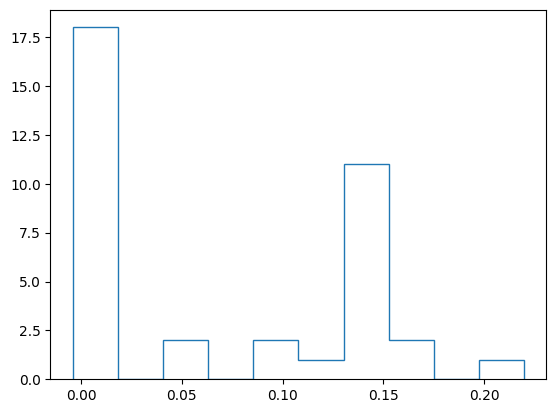

In [38]:
hist1 = np.histogram(dfSorted['z'])
plt.stairs(*hist1)

(array([18.,  0.,  2.,  0.,  2.,  1., 11.,  2.,  0.,  1.]),
 array([-0.00395511,  0.01841543,  0.04078597,  0.06315651,  0.08552705,
         0.10789759,  0.13026813,  0.15263868,  0.17500922,  0.19737976,
         0.2197503 ]),
 <BarContainer object of 10 artists>)

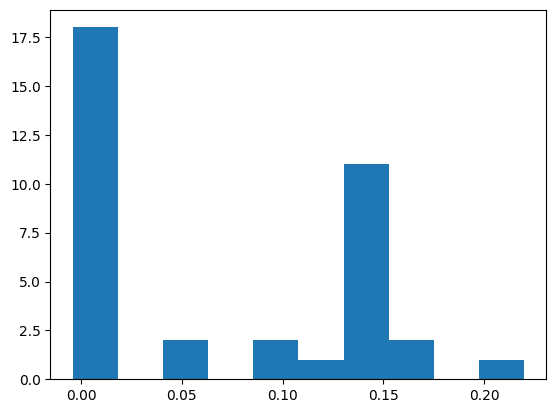

In [39]:
plt.hist(dfSorted['z'].to_list())

In [25]:
ra = dfnew['ra']
dec = dfnew['dec']

outDir = 'newSet'
outFiles = glob.glob(os.path.join('.', outDir, '*'))
if len(outFiles) == len(ra):
    print('Skipping populate')
else:
    for i in range(len(ra)):
        urlVar = f'https://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/'\
        f'getjpeg?TaskName=Skyserver.Explore.Image&ra={str(ra[i]).strip()}'\
        f'&dec={str(dec[i]).strip()}&scale=0.1&width=200&height=200'

    #     # tell the loop to pause for a bit - every 100 images
    #     if i%100==0:
    #         time.sleep(5)

        img_data = requests.get(urlVar).content
        with open(f'{outDir}/sdss_ra={ra[i]}_dec={dec[i]}.png', 'wb') as handler:
            handler.write(img_data)
            
        # Needs to be assigned after populate
    outFiles = glob.glob(os.path.join('.', outDir, '*'))

Skipping populate


In [26]:
# # remove red contaminants
dfnew['files'] = outFiles
redPercent = [0]*len(outFiles)
counter = 0
workDir = outDir

# lower boundary RED color range values; Hue (0 - 10)
lower1 = np.array([0, 80, 20])
upper1 = np.array([10, 255, 255])
 
# upper boundary RED color range values; Hue (160 - 180)
lower2 = np.array([160, 100, 20])
upper2 = np.array([179, 255, 255])

for i, x in enumerate(outFiles):
    testImgPath = x
    image = cv2.imread(testImgPath)
    result = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    lower_mask = cv2.inRange(image, lower1, upper1)
    upper_mask = cv2.inRange(image, lower2, upper2)
    full_mask = lower_mask + upper_mask;

    result = cv2.bitwise_and(result, result, mask=full_mask)
    dim = np.shape(full_mask)[0] 
    counts = np.count_nonzero(full_mask)
    percent = 100*counts/dim**2
    redPercent[i] = percent
    subtitle_string = f'{percent}% of the image is red'
    filename = testImgPath.split('\\')[-1]
#     print(f'{filename}, {subtitle_string}')
#     if percent > 50.0:
#         counter += 1
# #         print('To be removed')
#     else:
#         pass

dfnew['redPercent'] = redPercent # add new column of the red percentage of an image
redList = (dfnew['redPercent'] >= 50) # percentage threshold of how much red is in the image
dfnew_filtered = dfnew[dfnew['redPercent'] <= 50]
# dfnew_filtered.shape

redInds = np.where(redList)[0] # the indices of the hot pixel images to be removed
print(f'{len(redInds)} of the images are over 50 percent red')
print(f'{len(redInds)/len(outFiles)*100:.2f} % of images are over 50 percent red')
# for n in redInds:
#     imStr = dfnew['files'].to_list()[n]
# #     imStr = outDir + red
#     im = cv2.imread(imStr)[:,:,::-1] # [:,:,::-1] switches rgb to bgr and vice versa
#     plt.figure
#     plt.imshow(im)
#     plt.show()


4 of the images are over 50 percent red
12.12 % of images are over 50 percent red


In [27]:
# dfnew_filtered

In [28]:

blueDf = brightDF1.loc[(brightDF1['modelMag_r'] < rmag_threshold) \
                       & (brightDF1['u_g'] < 2.5) \
                       & (brightDF1['petroRad_r'] > 15) \
                       & (brightDF1['g_z'] < 2.2)]

In [29]:
blueDf

,files,name,labels,reds,objID,type,ra,dec,modelMag_r,u_g,g_z,g_r,g_i,r_i,r_z,petroRad_r
147,sdss_ra=49.5667_dec=41.2776.png,PCC-1937,1,9.0875,1237661083199209709,GALAXY,49.566712,41.277521,18.45231,1.636200,1.588932,0.856129,1.295055,0.438927,0.732803,18.01882
175,sdss_ra=49.7333_dec=41.5787.png,PCC-3303,1,4.1700,1237661059574270104,GALAXY,49.733335,41.578747,18.14951,1.672335,1.329027,0.789616,1.173399,0.383783,0.539412,18.01974
211,sdss_ra=49.9449_dec=41.5293.png,PCC-4979,1,14.6750,1237661059574333557,GALAXY,49.950960,41.547161,14.49405,0.217379,1.436186,0.775021,0.852034,0.077013,0.661165,258.41160
213,sdss_ra=49.9523_dec=41.5579.png,PCC-5047,1,28.5350,1237661059574333557,GALAXY,49.950960,41.547161,14.49405,0.217379,1.436186,0.775021,0.852034,0.077013,0.661165,258.41160
217,sdss_ra=49.9635_dec=41.5354.png,PCC-5136,1,25.4425,1237661059574333557,GALAXY,49.950960,41.547161,14.49405,0.217379,1.436186,0.775021,0.852034,0.077013,0.661165,258.41160
222,sdss_ra=49.9686_dec=41.5498.png,PCC-5163,1,9.2000,1237661059574333557,GALAXY,49.950960,41.547161,14.49405,0.217379,1.436186,0.775021,0.852034,0.077013,0.661165,258.41160


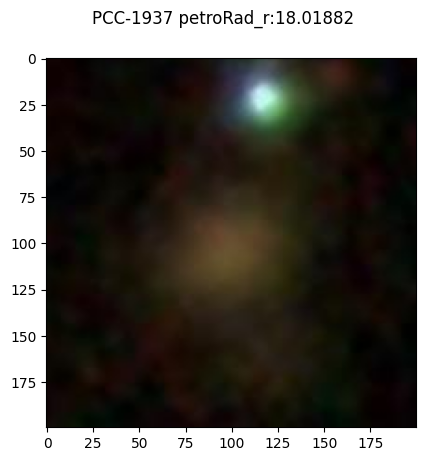

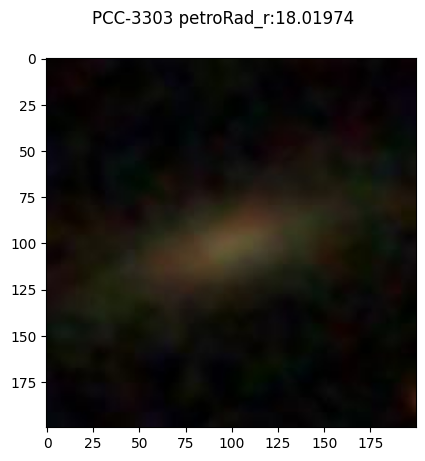

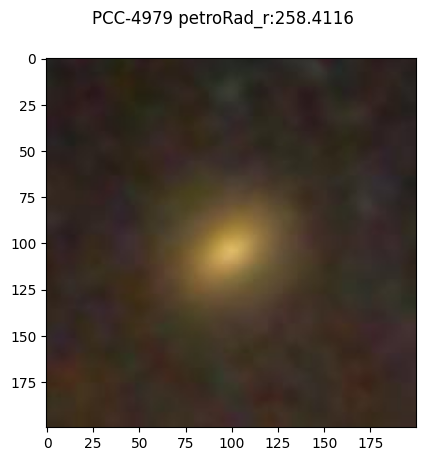

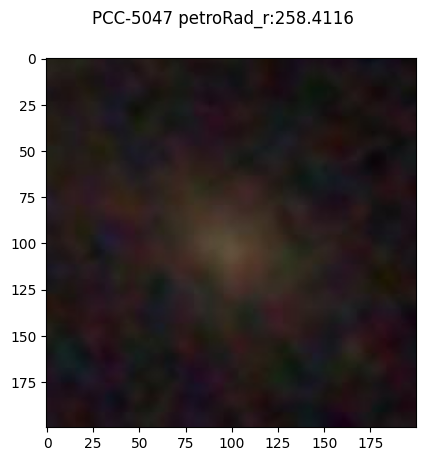

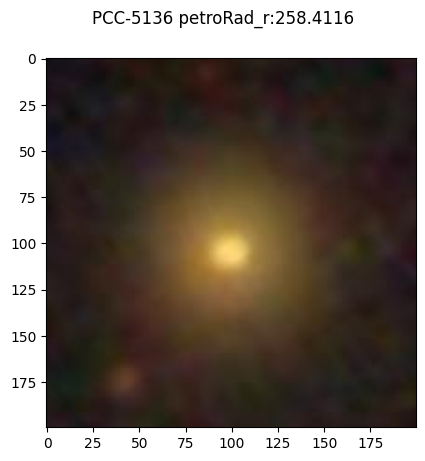

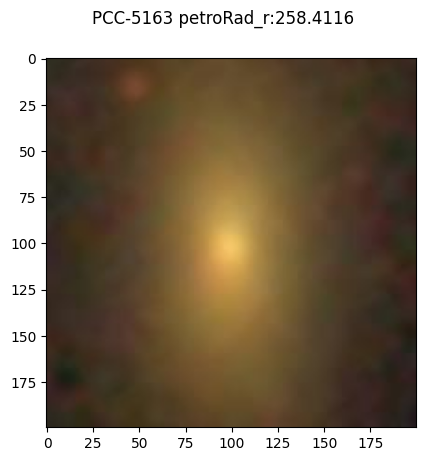

In [30]:
names = blueDf['name']
names = names.to_list()
rads = blueDf['petroRad_r']
rads = rads.to_list()

for i, x in enumerate(blueDf['files']):
#     print(i)
    path = os.path.join('SDSS-png', x)
    image = cv2.imread(path)
    image = image[:,:,::-1] ## currently in bgr, needs to be rgb
    plt.imshow(image)
    plt.suptitle(names[i] + ' petroRad_r:'+ str(rads[i]))
    plt.show()